In [1]:
import itertools
import json
import os
import re

import joblib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import scipy as sp
import statsmodels.api as sm
import seaborn as sns
import tqdm

from evaluation import evaluate

In [2]:
def parse_log(logpath: str, *keys: str) -> list:
    log = []
    with open(logpath) as f:
        while (line := f.readline()):
            data = json.loads(line)
            logline = {}
            if 'all' in keys:
                logline = data
            else:
                for key in keys:
                    if ':' in key:
                        group, prop = key.split(':')
                        logline[prop] = data[group][prop]
                    else:
                        logline[key] = data[key]
            log.append(logline)
    return log

def save_parameter_stats(logpath: str, statspath: str):
    with open(statspath, 'w') as f:
        log = parse_log(
            logpath,
            'Parameters:SendTolerance',
            'Parameters:Transmission',
            'Statistics:Updates',
            'Statistics:Messages',
            'Statistics:RuntimeInSeconds')
        json.dump(log, f)
        
def save_scalability_stats(statspath: str, *logpaths: str):
    with open(statspath, 'w') as f:
        logs = [
            parse_log(
                logpath,
                'Parameters:SendTolerance',
                'Parameters:Transmission',
                'Statistics:Updates',
                'Statistics:Nodes',
                'Statistics:Edges',
                'Statistics:Messages',
                'Statistics:RuntimeInSeconds',
                'Statistics:GraphBuildTimeInSeconds',
                'Statistics:PartitionTimeInSeconds')
            for logpath in logpaths]
        json.dump(logs, f)

def save_reachability(logpath: str, reachpath: str):
    log = parse_log(logpath, 'Statistics:MessagesReachabilities')
    reaches = (
        np.array(run['MessagesReachabilities'], dtype=np.int8) 
        for run in log)
    np.savez(
        reachpath, 
        **{f'r{r}': data for r, data in enumerate(reaches, start=1)})

def save_degrees(logpath: str, degpath: str):
    log = parse_log(logpath, 'Statistics:Degrees')
    degrees = (np.array(run['Degrees'], dtype=np.int16) for run in log)
    np.savez(
        degpath, 
        **{f'd{d}': data for d, data in enumerate(degrees, start=1)})

def save_symptoms(logpath: str, degpath: str):
    log = parse_log(logpath, 'SymptomScores')
    scores = (np.array(run['SymptomScores'], dtype=np.float64) for run in log)
    np.savez(
        degpath,
        **{f's{s}': data for s, data in enumerate(scores, start=1)})

def load_npz(path: str) -> list:
    with np.load(path) as data:
        arrs = list(data.values())
    return arrs

def load_data(datapath: str):
    with open(datapath) as f:
        return json.load(f)

def msg_reach(init, r0, alpha, gamma, eps=1e-7):
    num = np.log(np.maximum(eps, gamma * alpha * r0) / np.maximum(eps, init))
    den = np.log(alpha)
    return np.maximum(1, 1 + num / den)

def compare_reaches(symptoms, reaches, alpha, gamma):
    reaches = reaches[reaches != 0].astype(np.int64)
    symptoms = symptoms.astype(np.float64)
    inits = alpha * symptoms
    r0 = symptoms.mean()
    expected = np.array([
        msg_reach(init=i, alpha=alpha, gamma=gamma, r0=r0)
        for i in inits])
    expected = (expected.mean(), sp.stats.sem(expected))
    actual = (reaches.mean(), sp.stats.sem(reaches))
    return expected, actual

## Parameter Experiments

In [8]:
def save_tolerance_data(df: pd.DataFrame, y: str, label: str = None):
    df2 = df.copy()
    df2.loc[:, 'SendTolerance'] *= 10
    df2.loc[:, 'SendTolerance'] = df2.SendTolerance.astype(int)
    df_save = df2[['SendTolerance', y]]
    df_save.index = df_save[y]
    df_save = df_save.drop(columns=y)
    df_save.to_csv(f'figures//tolerance-{(label or y).lower()}.csv')

In [3]:
graphs = ('lfr', 'power', 'geometric')
lognames = ('lfr-1642133470', 'power-1642133471', 'geometric-1642133470')
logpaths = {
    name.split('-')[0]: os.path.join(evaluate.PARAMS_DIR, f'{name}.log') 
    for name in lognames}
statpaths = {
    graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-stat.json') 
    for graph in graphs}
reachpaths = {
    graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-reach.npz') 
    for graph in graphs}
degpaths = {
    graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-deg.npz') 
    for graph in graphs}
sympaths = {
    graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-sym.npz') 
    for graph in graphs}

In [5]:
par = joblib.Parallel(n_jobs=len(graphs))
par(joblib.delayed(save_parameter_stats)(logpaths[g], statpaths[g]) 
    for g in graphs)
par(joblib.delayed(save_reachability)(logpaths[g], reachpaths[g]) 
    for g in graphs)
par(joblib.delayed(save_degrees)(logpaths[g], degpaths[g]) 
    for g in graphs)
par(joblib.delayed(save_symptoms)(logpaths[g], sympaths[g]) 
    for g in graphs)

[None, None, None]

In [9]:
dfs = []
for graph, statpath in statpaths.items():
    stats = load_data(statpath)
    df = pd.DataFrame(stats)
    df['Graph'] = len(stats) * [graph]
    dfs.append(df)
df = pd.concat(dfs)

analyze = ('Updates', 'RuntimeInSeconds', 'Messages')

for stat in analyze:
    grouped = df.groupby(['Graph', 'Transmission'])
    df[f'Normalized{stat}'] = df[stat] / grouped[stat].transform('max')

In [10]:
save_tolerance_data(
    df[df['Transmission'] > 0.3], 'NormalizedUpdates', 'updates')
save_tolerance_data(df, 'NormalizedRuntimeInSeconds', 'runtime')
save_tolerance_data(df, 'NormalizedMessages', 'messages')

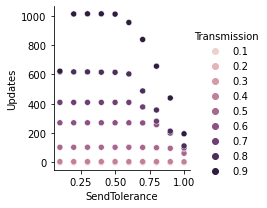

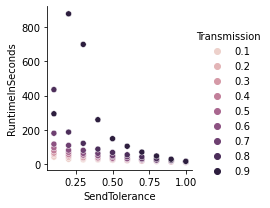

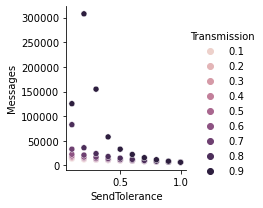

In [11]:
data = df.loc[(df['Graph'] == 'power')]
for stat in analyze:
    sns.relplot(
        data=data, 
        x='SendTolerance', 
        y=stat, 
        hue='Transmission', 
        legend='full', 
        height=3);

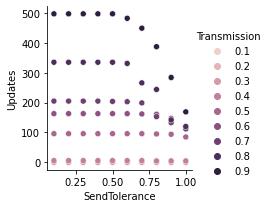

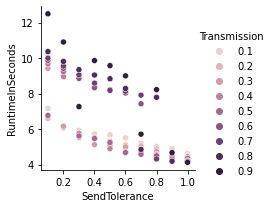

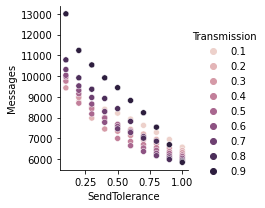

In [12]:
data = df.loc[(df['Graph'] == 'lfr')]
for stat in analyze:
    sns.relplot(
        data=data, 
        x='SendTolerance', 
        y=stat, 
        hue='Transmission', 
        legend='full',
        height=3);

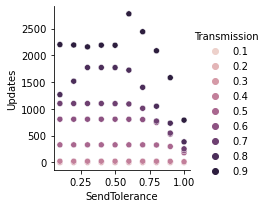

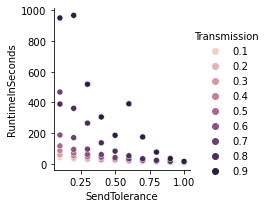

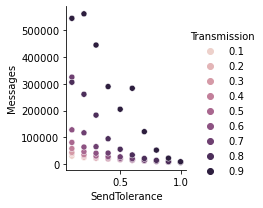

In [13]:
data = df.loc[(df['Graph'] == 'geometric')]
for stat in analyze:
    sns.relplot(
        data=data, 
        x='SendTolerance', 
        y=stat, 
        hue='Transmission', 
        legend='full', 
        height=3);

In [14]:
df.groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.976931,0.114022,0.407127,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.792070,0.173117,0.360168,0.698015,0.852839,0.919175,1.000000
0.3,27.0,0.667564,0.205999,0.200947,0.516139,0.744900,0.841631,0.900678
0.4,27.0,0.577064,0.237012,0.127247,0.382841,0.643892,0.795796,0.852652
0.5,27.0,0.521403,0.249592,0.083775,0.321494,0.576412,0.740798,0.833283
0.6,27.0,0.484259,0.247898,0.062992,0.285484,0.540627,0.704322,0.804584
0.7,27.0,0.434455,0.247479,0.044707,0.218348,0.489732,0.653806,0.773755
0.8,27.0,0.395784,0.246374,0.032674,0.156983,0.407149,0.623684,0.739783
0.9,27.0,0.361084,0.241661,0.026630,0.127976,0.364391,0.573125,0.705202


In [15]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.735166,0.264077,0.432708,0.642773,0.852839,0.886395,0.919952
0.3,3.0,0.585251,0.290363,0.288641,0.443408,0.598175,0.733556,0.868936
0.4,3.0,0.451462,0.329086,0.216953,0.263363,0.309772,0.568716,0.827660
0.5,3.0,0.380497,0.348059,0.177619,0.179548,0.181478,0.481936,0.782395
0.6,3.0,0.328166,0.344488,0.112195,0.129528,0.146861,0.436152,0.725443
0.7,3.0,0.280119,0.321944,0.069145,0.094837,0.120529,0.385606,0.650682
0.8,3.0,0.261817,0.326157,0.046271,0.074202,0.102132,0.369590,0.637047
0.9,3.0,0.223059,0.289258,0.030612,0.056739,0.082865,0.319282,0.555700


In [16]:
df.groupby('SendTolerance')['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.954478,0.143593,0.334744,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.761621,0.182443,0.363107,0.655889,0.726222,0.937655,1.000000
0.3,27.0,0.587418,0.177284,0.203040,0.522837,0.587717,0.648022,0.905787
0.4,27.0,0.496281,0.208412,0.126369,0.331330,0.480395,0.598242,0.872443
0.5,27.0,0.441393,0.230038,0.085580,0.249739,0.414378,0.580090,0.852423
0.6,27.0,0.405706,0.231071,0.067475,0.231222,0.369347,0.522420,0.813844
0.7,27.0,0.340996,0.212528,0.047921,0.175928,0.304318,0.475506,0.791524
0.8,27.0,0.305561,0.211061,0.036562,0.122483,0.260689,0.464477,0.751396
0.9,27.0,0.254742,0.182567,0.029741,0.100008,0.199819,0.413859,0.682348


In [68]:
grouped = df[df['Transmission'] == 0.8].groupby('SendTolerance')
grouped['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.768258,0.293535,0.429466,0.679149,0.928832,0.937655,0.946478
0.3,3.0,0.620060,0.316001,0.278307,0.479258,0.680209,0.790936,0.901664
0.4,3.0,0.474165,0.352780,0.200970,0.275026,0.349082,0.610762,0.872443
0.5,3.0,0.406039,0.387505,0.156079,0.182847,0.209616,0.531019,0.852423
0.6,3.0,0.351912,0.387489,0.124524,0.128205,0.131886,0.465605,0.799325
0.7,3.0,0.216092,0.218744,0.081925,0.089884,0.097843,0.283176,0.468509
0.8,3.0,0.292604,0.397391,0.055983,0.063207,0.070432,0.410914,0.751396
0.9,3.0,0.164827,0.207589,0.039524,0.045017,0.050510,0.227478,0.404446


In [69]:
df.groupby('SendTolerance')['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,18.0,0.951180,0.116468,0.614018,1.000000,1.000000,1.000000,1.000000
0.2,18.0,0.980269,0.058340,0.790137,1.000000,1.000000,1.000000,1.000000
0.3,18.0,0.987641,0.052435,0.777538,1.000000,1.000000,1.000000,1.000000
0.4,18.0,0.988101,0.049681,0.789057,1.000000,1.000000,1.000000,1.000000
0.5,18.0,0.987458,0.049720,0.788337,0.998497,1.000000,1.000000,1.000000
0.6,18.0,0.990564,0.015875,0.941757,0.988606,1.000000,1.000000,1.000000
0.7,18.0,0.931694,0.081806,0.789303,0.885412,0.980511,0.999074,1.000000
0.8,18.0,0.825651,0.152175,0.578606,0.708656,0.806003,0.983516,1.000000
0.9,18.0,0.680692,0.222353,0.345219,0.491181,0.651528,0.904576,1.000000


In [70]:
grouped = df[df['Transmission'] == 0.8].groupby('SendTolerance')
grouped['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,0.904735,0.165004,0.714205,0.857103,1.000000,1.000000,1.000000
0.2,3.0,0.951898,0.083315,0.855693,0.927847,1.000000,1.000000,1.000000
0.3,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.4,3.0,0.998920,0.001871,0.996759,0.998379,1.000000,1.000000,1.000000
0.5,3.0,0.998191,0.002659,0.995138,0.997287,0.999436,0.999718,1.000000
0.6,3.0,0.979249,0.008018,0.972379,0.974844,0.977310,0.982685,0.988060
0.7,3.0,0.791400,0.002408,0.789303,0.790086,0.790868,0.792449,0.794030
0.8,3.0,0.632949,0.082893,0.578606,0.585244,0.591883,0.660120,0.728358
0.9,3.0,0.394097,0.042666,0.345219,0.379205,0.413191,0.418536,0.423881


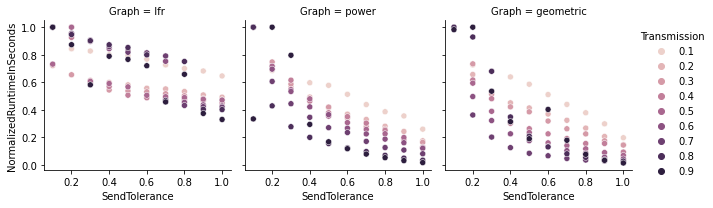

In [17]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

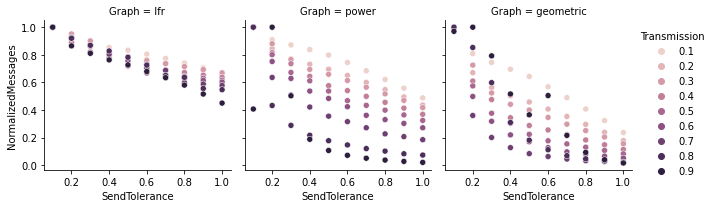

In [18]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedMessages',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

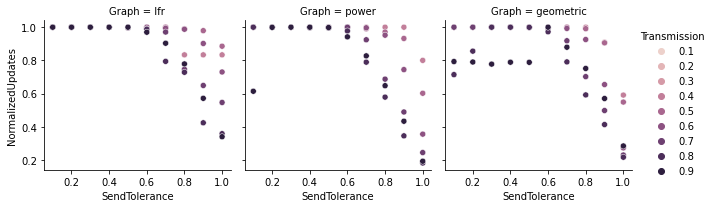

In [19]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedUpdates',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

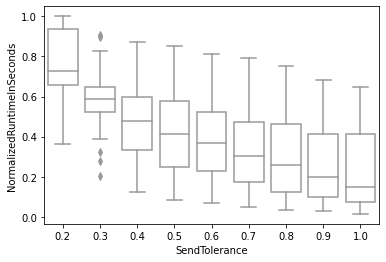

In [20]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    color='white');

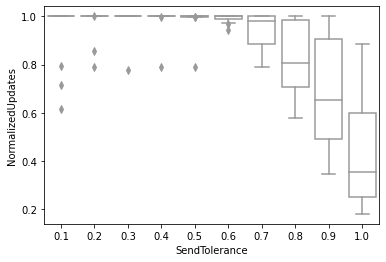

In [21]:
sns.boxplot(
    data=df,
    x='SendTolerance',
    y='NormalizedUpdates',
    color='white');

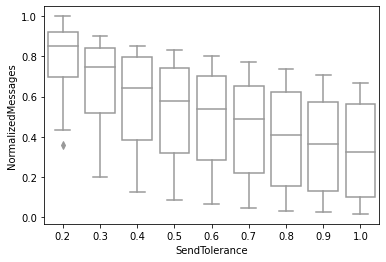

In [22]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedMessages',
    color='white');

In [23]:
def save_ratio_data(df: pd.DataFrame, tol_or_trans: str, label: str = None):
    df2 = df.copy()
    df2.loc[:, tol_or_trans] *= 10
    df2.loc[:, tol_or_trans] = df2[tol_or_trans].astype(int)
    df_save = df2[[tol_or_trans, 'RatioValue']]
    df_save.index = df_save.RatioValue
    df_save = df_save.drop(columns='RatioValue')
    df_save.to_csv(f'figures//ratio-{(label or tol_or_trans).lower()}.csv')
    
def compare_all_reaches(graph: str, reachpaths: dict, sympaths: dict):
    reaches = load_npz(reachpaths[graph])
    symptoms = load_npz(sympaths[graph])
    gammas = np.arange(0.1, 1.1, 0.1)
    alphas = np.arange(0.1, 1, 0.1)
    loop = list(enumerate((itertools.product(gammas, alphas))))
    records = []
    for i, (gamma, alpha) in tqdm.tqdm(loop):
        expected, actual = compare_reaches(
            symptoms=symptoms[i], 
            reaches=reaches[i], 
            alpha=alpha, 
            gamma=gamma)
        records.append({
            'Graph': graph,
            'Transmission': alpha,
            'SendTolerance': gamma,
            'ExpectedValue': expected[0],
            'ExpectedStdErr': expected[1],
            'ActualValue': actual[0],
            'ActualStdErr': actual[1]})
    return records

def div_stderr(numval, numerr, denval, denerr):
    norm = np.linalg.norm([numerr / numval, denerr / denval])
    return np.abs(numval / denval) * norm

def add_stderr(errs, average=True):
    stderr = np.linalg.norm(errs)
    if average:
        stderr /= len(errs)
    return stderr

In [24]:
reaches = [compare_all_reaches(g, reachpaths, sympaths) for g in graphs]
reaches = pd.concat([pd.DataFrame(r) for r in reaches])
reaches['RatioValue'] = reaches.ActualValue / reaches.ExpectedValue
reaches['RatioStdErr'] = 1.96 * div_stderr(
    reaches.ActualValue, 
    reaches.ActualStdErr, 
    reaches.ExpectedValue, 
    reaches.ExpectedStdErr)

100%|████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 37.47it/s]


In [133]:
save_ratio_data(reaches, 'Transmission', label='transmission')
save_ratio_data(reaches, 'SendTolerance', label='tolerance')

In [27]:
reaches.RatioValue.describe()

count    270.000000
mean       0.859302
std        0.277208
min        0.146862
25%        0.714699
50%        0.839766
75%        0.977028
max        1.836390
Name: RatioValue, dtype: float64

In [135]:
reaches.groupby('Graph')['ExpectedValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,2.971345,3.283482,1.046960,1.290184,1.849300,3.013868,22.370391
lfr,90.0,2.971867,3.286367,1.045951,1.289094,1.849792,3.017983,22.381097
power,90.0,2.971937,3.287250,1.045533,1.288558,1.850721,3.019051,22.384189


In [136]:
reaches.groupby('Graph')['ActualValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,1.726149,0.695810,1.0,1.181730,1.532784,2.166239,3.285371
lfr,90.0,2.007048,0.993219,1.0,1.269741,1.735897,2.566260,4.475418
power,90.0,2.105625,0.769905,1.0,1.645683,2.157902,2.740100,3.333299


In [137]:
reaches.groupby('Graph')['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,0.765580,0.206542,0.146862,0.659882,0.769454,0.923396,1.155487
lfr,90.0,0.852294,0.229115,0.199964,0.728658,0.837352,0.948300,1.436018
power,90.0,0.960033,0.343386,0.148913,0.782093,0.939176,1.115862,1.836390


In [6]:
reaches.groupby(['SendTolerance'])['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.575648,0.213495,0.146862,0.440069,0.627527,0.711900,0.943200
0.2,27.0,0.647414,0.203344,0.207755,0.554205,0.704742,0.757589,0.981058
0.3,27.0,0.687068,0.186137,0.266937,0.628614,0.705045,0.796482,0.995375
0.4,27.0,0.745254,0.179034,0.327403,0.696234,0.763639,0.829107,1.069636
0.5,27.0,0.795023,0.166631,0.409180,0.733907,0.781625,0.853619,1.118980
0.6,27.0,0.870626,0.162865,0.519537,0.792938,0.838426,0.926621,1.189649
0.7,27.0,0.957579,0.182423,0.655453,0.839636,0.882099,1.053901,1.452222
0.8,27.0,1.062421,0.203555,0.832083,0.914404,1.005750,1.116851,1.586035
0.9,27.0,1.118122,0.252613,0.905135,0.937177,0.984993,1.261982,1.768438


In [139]:
reaches.groupby(['Transmission'])['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Transmission,,,,,,,,
0.1,30.0,0.837642,0.101279,0.667160,0.749612,0.833293,0.938698,0.981058
0.2,30.0,0.841007,0.096719,0.662569,0.769129,0.832159,0.926654,1.069636
0.3,30.0,0.860933,0.117066,0.626085,0.786586,0.858914,0.918275,1.189649
0.4,30.0,0.899255,0.168355,0.627527,0.777867,0.913273,0.977028,1.367574
0.5,30.0,0.936591,0.224551,0.599177,0.765323,0.884330,1.077939,1.437183
0.6,30.0,0.933730,0.260871,0.524322,0.731768,0.929076,1.067628,1.464517
0.7,30.0,0.932738,0.351506,0.427878,0.670263,0.887386,1.099303,1.768438
0.8,30.0,0.864944,0.421433,0.295081,0.524265,0.769973,1.117747,1.836390
0.9,30.0,0.626880,0.394472,0.146862,0.293142,0.528139,0.909154,1.462022


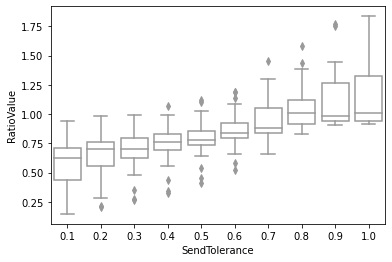

In [140]:
sns.boxplot(
    data=reaches,
    x=reaches.SendTolerance.round(2),
    y=reaches.RatioValue,
    color='white');

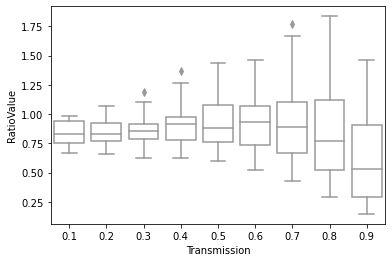

In [141]:
sns.boxplot(
    data=reaches,
    x=reaches.Transmission.round(2),
    y='RatioValue',
    color='white');

In [142]:
data = reaches[['Transmission', 'RatioValue']].copy()
data.index = data.RatioValue

In [143]:
select = reaches[
    (reaches['Transmission'] == 0.8) & 
    (reaches['SendTolerance'] == 0.6)]
select[['Graph', 'RatioValue', 'RatioStdErr']]

,Graph,RatioValue,RatioStdErr
52,lfr,0.884646,0.140949
52,power,0.904169,0.144060
52,geometric,0.744948,0.118691


In [144]:
ratios = select.RatioValue.values
errs = select.RatioStdErr.values
# Already includes 1.96 factor
mean = round(ratios.mean(), 3)
err = round(add_stderr(errs), 3)
print(f'({mean} +/- {err})x expected reachability')

(0.845 +/- 0.078)x expected reachability


## Scalability Experiments

In [249]:
def is_log(file: str, graph=None):
    if graph is None:
        graph = ''
    return file.startswith(graph) and file.endswith('log')

def get_logfiles(graph: str, directory: str):
    return [
        os.path.join(directory, f)
        for f in os.listdir(directory) if is_log(f, graph)]

In [250]:
graphs = {'lfr': 1, 'power': 2, 'geometric': 3}
logpaths = {
    g: get_logfiles(g, evaluate.SCALABILITY_DIR)
    for g in graphs}
statpaths = {
    g: os.path.join(evaluate.SCALABILITY_DIR, f'{g}-stat.json') 
    for g in graphs}

In [251]:
par = joblib.Parallel(n_jobs=len(graphs))
par(joblib.delayed(save_scalability_stats)(statpaths[g], *logpaths[g]) 
    for g in graphs)

[None, None, None]

In [282]:
dfs = []
for graph, statpath in statpaths.items():
    stats = load_data(statpath)
    graph_dfs = []
    for s in stats:
        df = pd.DataFrame(s)
        df['Graph'] = len(s) * [graph]
        graph_dfs.append(df)
    df = pd.concat(graph_dfs)
    dfs.append(df)
df = pd.concat(dfs)
# Accidentally collected more power samples than others.
power = df[df['Graph'] == 'power'].groupby('Nodes').head(10)
not_power = df[df['Graph'] != 'power']
df = pd.concat([power, not_power])

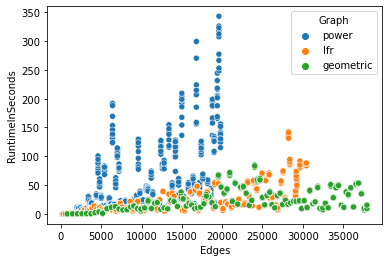

In [294]:
sns.scatterplot(
    data=df,
    x=df.Edges,
    y=df.RuntimeInSeconds,
    hue=df.Graph);

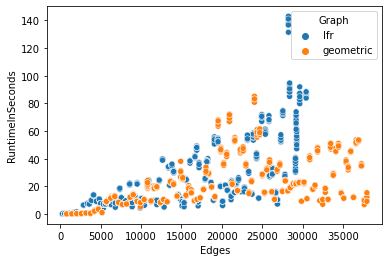

In [284]:
mask = df[df['Graph'] != 'power']
sns.scatterplot(
    data=df[df['Graph'] != 'power'],
    x=df.Edges[df['Graph'] != 'power'],
    y=df.RuntimeInSeconds[df['Graph'] != 'power'],
    hue=df.Graph[df['Graph'] != 'power']);

In [285]:
df.quantile(0.25)

SendTolerance                 0.600000
Transmission                  0.800000
Updates                     352.000000
Nodes                      2574.250000
Edges                      7519.750000
Messages                   7360.000000
RuntimeInSeconds             10.473050
GraphBuildTimeInSeconds       1.802550
PartitionTimeInSeconds        0.385575
Name: 0.25, dtype: float64

In [286]:
df.quantile(0.5)

SendTolerance                  0.60000
Transmission                   0.80000
Updates                      849.50000
Nodes                       5049.50000
Edges                      14590.50000
Messages                   15449.00000
RuntimeInSeconds              19.67120
GraphBuildTimeInSeconds        3.07285
PartitionTimeInSeconds         1.07130
Name: 0.5, dtype: float64

In [287]:
df.quantile(0.75)

SendTolerance                  0.60000
Transmission                   0.80000
Updates                     1655.25000
Nodes                       7524.50000
Edges                      22116.00000
Messages                   29994.50000
RuntimeInSeconds              37.57320
GraphBuildTimeInSeconds        4.77895
PartitionTimeInSeconds         2.29530
Name: 0.75, dtype: float64

In [288]:
df.quantile(0.95)

SendTolerance                  0.60000
Transmission                   0.80000
Updates                     3255.15000
Nodes                       9504.60000
Edges                      33167.20000
Messages                   66329.45000
RuntimeInSeconds              93.32602
GraphBuildTimeInSeconds        7.42898
PartitionTimeInSeconds         3.66757
Name: 0.95, dtype: float64

In [289]:
result = sp.stats.linregress(df.Edges, df.RuntimeInSeconds)
tinv = lambda p, df: abs(sp.stats.t.ppf(p / 2, df))
ts = tinv(0.05, len(df.Edges) - 2)
print(f"Slope (95%): {result.slope:.6f} +/- {ts * result.stderr:.6f}")
print(f"Intercept (95%): {res.intercept:.6f} +/- {ts * res.intercept_stderr:.6f}")
print(f'Correlation coeff: {result.rvalue:.6f}')

Slope (95%): 0.000914 +/- 0.000133
Intercept (95%): 15.601230 +/- 1.562048
Correlation coeff: 0.239550


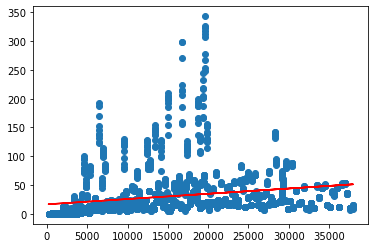

In [290]:
plt.plot(df.Edges, df.RuntimeInSeconds, 'o', label='original data')
plt.plot(df.Edges, result.intercept + result.slope * df.Edges, 'r', label='fitted line');

In [291]:
def save_runtime_data(df: pd.DataFrame):
    df2 = df.copy()
    df_save = df2[['Edges', 'RuntimeInSeconds', 'Graph']]
    df_save.index = df_save.Edges
    df_save.loc[:, 'Graph'] = [graphs[g] for g in df_save['Graph']]
    df_save = df_save.drop(columns='Edges')
    df_save.to_csv(f'figures//scalability.csv')

In [293]:
save_runtime_data(df)

## Real-World Experiments

In [20]:
settings = ('workplace', 'highschool12', 'conference')
lognames = (
    'workplace-1642112756', 
    'highschool12-1642112756', 
    'conference-1642112759')
logpaths = {
    name.split('-')[0]: os.path.join(evaluate.REAL_WORLD_DIR, f'{name}.log') 
    for name in lognames}

In [21]:
logs = {}

for setting, logpath in logpaths.items():
    log = parse_log(logpath, 'all')
    logs[setting] = {
        'stats': pd.DataFrame([run['Statistics'] for run in log]),
        'params': pd.DataFrame([run['Parameters'] for run in log]),
        'symptoms': pd.DataFrame([run['SymptomScores'] for run in log]),
        'exposures': pd.DataFrame([run['SymptomScores'] for run in log])}

for setting, log in logs.items():
    log['stats']['Setting'] = len(log['stats']) * [setting]

stats = pd.concat([logs[s]['stats'] for s in settings])
params = pd.concat([logs[s]['params'] for s in settings])

df = pd.concat([stats, params], axis=1)

conference = df.loc[df['Setting'] == 'conference']
workplace = df.loc[df['Setting'] == 'workplace']
school = df.loc[df['Setting'] == 'highschool12']

c_reaches = np.array([
    r for r in conference.MessagesReachabilities.values], 
    dtype=np.int8)
c_reaches = c_reaches[c_reaches != 0]
w_reaches = np.array([
    r for r in workplace.MessagesReachabilities.values], 
    dtype=np.int8)
w_reaches = w_reaches[w_reaches != 0]
s_reaches = np.array([
    r for r in school.MessagesReachabilities.values], 
    dtype=np.int8)
s_reaches = s_reaches[s_reaches != 0]
reaches = (c_reaches, w_reaches, s_reaches)

In [147]:
df.groupby('Setting')[['Radius']].describe()

Radius                                   
              count mean  std  min  25%  50%  75%  max
Setting                                               
conference     10.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
highschool12   10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
workplace      10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0

In [148]:
df.groupby('Setting')[['Diameter']].describe()

Diameter                                   
                count mean  std  min  25%  50%  75%  max
Setting                                                 
conference       10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
highschool12     10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
workplace        10.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0

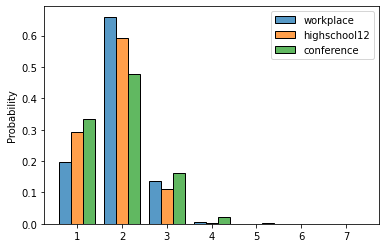

In [70]:
sns.histplot(
    data={s: r for s, r in zip(settings, reaches)},
    multiple='dodge',
    stat='probability',
    shrink=0.8,
    discrete=True,
    common_norm=False,
    common_bins=True);

In [71]:
df.groupby('Setting')[['RuntimeInSeconds']].describe()

RuntimeInSeconds                                          \
                        count      mean       std      min        25%   
Setting                                                                 
conference               10.0  20.65007  5.833157  14.1681  16.005500   
highschool12             10.0   2.30868  0.590946   1.4308   2.061325   
workplace                10.0   6.79757  1.787191   4.7251   5.440650   

                                            
                   50%        75%      max  
Setting                                     
conference    20.10785  23.884750  32.4736  
highschool12   2.36135   2.736450   3.1840  
workplace      6.81990   7.207975  10.7996

In [72]:
df.groupby('Setting')[['Messages']].describe()

Messages                                                         \
                count    mean          std     min      25%     50%      75%   
Setting                                                                        
conference       10.0  6223.2  1790.445990  4259.0  4748.00  6110.5  7040.00   
highschool12     10.0  2741.9   641.119065  1712.0  2580.00  2675.0  3183.25   
workplace        10.0  2833.0   690.842481  2000.0  2292.75  2834.0  2982.75   

                      
                 max  
Setting               
conference    9887.0  
highschool12  3597.0  
workplace     4352.0

In [18]:
df.groupby('Setting')[['ReachabilityRatio']].describe()

ReachabilityRatio                                                \
                         count     mean       std     min       25%      50%   
Setting                                                                        
conference                10.0  0.39180  0.006335  0.3845  0.387050  0.39030   
highschool12              10.0  0.28772  0.009545  0.2762  0.279675  0.28750   
workplace                 10.0  0.39682  0.007710  0.3878  0.392525  0.39565   

                                
                   75%     max  
Setting                         
conference    0.395675  0.4042  
highschool12  0.292750  0.3068  
workplace     0.397900  0.4118

In [150]:
ratios = []
for reach, setting in zip(reaches, settings):
    (expval, experr), (actval, acterr) = compare_reaches(
        symptoms=logs[setting]['symptoms'].to_numpy().flatten(), 
        reaches=reach, 
        alpha=0.8,
        gamma=0.6)
    ratval = actval / expval
    raterr = div_stderr(actval, acterr, expval, experr)
    ratios.append((ratval, raterr))
    val = round(ratval, 3)
    err = round(raterr, 3)
    print(f'{setting}:\t {val} +/- {err} x expected reachability')
mean = round(np.mean([r[0] for r in ratios]), 3)
err = round(1.96 * add_stderr([r[1] for r in ratios]), 3)
print(f'overall:\t ({mean} +/- {err})x expected reachability')

workplace:	 0.626 +/- 0.01 x expected reachability
highschool12:	 0.577 +/- 0.009 x expected reachability
conference:	 0.602 +/- 0.007 x expected reachability
overall:	 (0.601 +/- 0.01)x expected reachability
